# Do Aperture Photometry
This is the core of this pacakge to perform the aperture photometry. The process of aperture photometry is as follows:
- Read the parameters including PHOTAPER(aperture of photometry) from **tape.par** (paramter file)
- Run the 1st loop of the object files
- Read the target name, exposure time, JD or HJD from the FITS header
- Find the stars in the image over the (THRES) X (standard deviation of image) + (median of image)
- Make the list of 2d Gaussian fitting results for all of the found stars (background, peak, center, FWHM)
- Run the 2nd loop of the found stars
- Check if the found star is the stellar object or not by the FWHM, peak, and so on
- Estimate the average and standard deviation of the background sky brightness
- Reform the 2d-array of image by the SUBPIXEL method 
- Calculate the flux of star for each aperture 
- Write the photoemtry results to the text file (.apw) 
- Plot the photometry results over the image 

Read the parameters from **tape.tar** and move to the working directory. 

In [1]:
import sys, os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge, Circle
from astropy.io import fits
from astropy.modeling import models, fitting
from photlib import read_params, helio_jd, calc_jd, find_stars_th, sigma_clip, prnlog, airmass, fit_gauss_elliptical, cal_magnitude

# READ the parameter file
par = read_params()

# ==================================================================
# PARAMETERS for aperture photometry
# ==================================================================
WORKDIR = par['WORKDIR']
# CCD/Optics parameters
BINNING = int(par['BINNING'])
PSCALE = float(par['PSCALE'])
EGAIN = float(par['EGAIN'])
# Photometry parameters
BOX = int(par['STARBOX'])  # Box size for photometry and centroid
PHOT_APER = np.array(par['PHOTAPER'].split(','), float)  # Radius of aperture
N_APER = len(PHOT_APER)
SKY_ANNUL1, SKY_ANNUL2 = np.array(par['SKYANNUL'].split(','), float)  # inner and outer radius of sky region
SUBPIXEL = int(par['SUBPIXEL'])  # number of subpixel for detailed aperture photometry
# (FINDSTARS) parameters
THRES = float(par['THRES'])  # threshold for detection
SATU = int(par['SATU'])  # saturation level for exclusion
# (CHECK) paramters
FWHM_CUT1, FWHM_CUT2 = np.array(par['FWHMCUT'].split(','), float)
FWHM_ECC = 0.3
# Determine the plots for each star (Warning! too many pngs)
PLOT_FLAG = bool(int(par['STARPLOT']))
# GEN. the log file for the following process
LOGFILE = par['LOGFILE']
# Observatory information for HJD
LAT, LON, H = float(par['OBSLAT']), float(par['OBSLON']), float(par['OBSELEV'])

# MOVE to the working directory =======
CDIR = os.path.abspath(os.path.curdir)
os.chdir(WORKDIR)
#======================================

c:\Users\kang\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Make the list of the object files and print the parameters for aperture photoemtry

In [2]:
# -------------------------------------------------------------------------
# GEN. the list of FITS files for aperture photometry
# YOU SHOULD CUSTOMIZE THIS SECTION FOR YOUR FILE NAMING RULES
# ------------------------------------------------------------------------
flist = glob('wobj*.fits')
flist.sort()

# DISPLAY the information of photometry
NFRAME = len(flist)
prnlog(f"#WORK: run_photometry")
prnlog(f"#WORK DIR: {WORKDIR}")
prnlog(f"#TOTAL NUMBER of FILES: {NFRAME}")
prnlog(f"#THRES = {THRES}")
prnlog(f"#SATU. LEVEL = {SATU}")
prnlog(f"#PHOT_APER: {PHOT_APER}")
prnlog(f"#SKY_ANNUL: {[SKY_ANNUL1, SKY_ANNUL2]}")
prnlog(f"#SUBPIXEL: {SUBPIXEL}")


#WORK: run_photometry
#WORK DIR: ./180326-HAT-P-12b
#TOTAL NUMBER of FILES: 44
#THRES = 5.0
#SATU. LEVEL = 60000
#PHOT_APER: [10. 20. 30.]
#SKY_ANNUL: [30.0, 40.0]
#SUBPIXEL: 5


## [Optional] Example of Process
**SKIP THIS SECTION**, IF YOU WANT TO RUN PHOTOMETRY FOR ALL IMAGES

Show the example of the process in an image (for the first image)

In [3]:
print(f"We have {len(flist)} files")


We have 44 files


Read the 2d-array and the header information from the FITS

In [4]:
# SELECT the number of file
inum = 0

# READ the file name of selected image 
fname = flist[inum]
print(f"{inum=}, {fname=}")

fidx = os.path.splitext(fname)[0]
print(f"READ {fidx}")

# READ the FITS file
hdu = fits.open(fname)[0]
img, hdr = hdu.data, hdu.header
ny, nx = img.shape
DATEOBS = hdr['DATE-OBS']
TARGET = hdr['OBJECT']
EXPTIME = hdr['EXPTIME']
FILTER = hdr['FILTER']
HJD = hdr.get('HJD')
if HJD is None:
    try:
        RA = hdr['RA']
        Dec = hdr['Dec']
        HJD = helio_jd(DATEOBS, RA, Dec, exptime=EXPTIME, LAT=LAT, LON=LON, H=H)
    except:
        HJD = calc_jd(DATEOBS, exptime=EXPTIME)

AIRMASS = hdr.get('AIRMASS')
if AIRMASS is None:
    try:
        AIRMASS = airmass(hdr.get('ALT'))
    except:
        AIRMASS = 0
# DISPLAY
prnlog(f"#RUN:  {inum+1} / {NFRAME}")
prnlog(f"#IMAGE/DATE-OBS: {fidx} {[nx, ny]} {DATEOBS}")
prnlog(f"#OBJECT/EXPTIME/FILTER: {TARGET} {EXPTIME} {FILTER}")

# IMAGE processing for photometry and plot
# CALC. the sigma of image
iavg, imed, istd = sigma_clip(img[BOX:-BOX, BOX:-BOX])
prnlog(f"#IMAGE STATS: {imed:.2f} ({istd:.2f})")

inum=0, fname='wobject-000115.fits'
READ wobject-000115
#RUN:  1 / 44
#IMAGE/DATE-OBS: wobject-000115 [2048, 2048] 2018-03-26T14:04:06
#OBJECT/EXPTIME/FILTER: hat-p-12b 200.0 R
#IMAGE STATS: 3057.72 (59.18)


Calculate the statistics of the image and find the stars with the THRES parameter

In [5]:

# IMAGE processing for photometry and plot
# CALC. the sigma of image
iavg, imed, istd = sigma_clip(img[BOX:-BOX, BOX:-BOX])
prnlog(f"#IMAGE STATS: {imed:.2f} ({istd:.2f})")

# FIND the stars
ally, allx = find_stars_th(img, imed + istd * THRES, saturation=(True, SATU),
                            detection_area=int(FWHM_CUT1), margin=BOX)

#IMAGE STATS: 3057.72 (59.18)
 - NUMBER of detected stars: 23


Find and save the fitting parameters of all stars with 2d-Gauissan function.

In [6]:
results = []
# LOOP of the stars found by thresholds
for fx, fy in zip(allx, ally):
    # CHECK the margin stars
    if (fx > nx-BOX) | (fx < BOX) | (fy > ny-BOX) | (fy < BOX): continue

    # DEFINE the box for fitting
    x0, y0 = int(fx) - BOX, int(fy) - BOX
    data = img[(y0):(y0 + 2 * BOX), (x0):(x0 + 2 * BOX)].copy()

    # FIT the stellar profile with 2D Gaussian function
    results.append(fit_gauss_elliptical([y0, x0], data))
    del data

Run aperture photometry and show the results

In [7]:
xlist, ylist = [], [] # to exclude the duplicate stars 
# LOOP of the results by fitting the stars
for maxi, background, peak, cy, cx, fwhm1, fwhm2, ang in results:
    # CHECK the margin stars
    if (cx > nx - BOX) | (cx < BOX) | (cy > ny - BOX) | (cy < BOX): continue

    # CALC FWHM in arcsec
    pfwhm1, pfwhm2 = fwhm1 * PSCALE, fwhm2 * PSCALE

    # CHECK the condition of star
    error_msg = ''
    if peak < istd:
        error_msg += 'TOO WEAK, '
    if (fwhm2 < FWHM_CUT1) | (fwhm2 > FWHM_CUT2):
        error_msg += 'TOO LARGE/SMALL, '
    if fwhm1 / fwhm2 < FWHM_ECC:
        error_msg += 'TOO OVAL, '
    if len(xlist) >= 1:
        c_rsq = (np.array(xlist) - cx)**2 + (np.array(ylist) - cy)**2
        if min(c_rsq) < FWHM_CUT2 ** 2:
            error_msg += 'TOO CLOSE, '
    if error_msg != '':
        print(f'{cx:4.0f} {cy:4.0f} [FAIL] FWHM={pfwhm2:.1f}" PEAK={peak:.1f} A/B={fwhm1/fwhm2:.1f} ' +
                f'{error_msg}')
        continue

    # DEFINE the starting index of BOX in the imgae
    x0, y0 = int(cx) - BOX, int(cy) - BOX
    # CROP the image in the BOX
    data = img[(y0):(y0 + 2 * BOX), (x0):(x0 + 2 * BOX)].copy()
    # DEFINE the coordinate of the center in the image
    cx_data, cy_data = (cx - x0), (cy - y0)
    # DEFINE the arrays of coordinates and radii from the center
    yy_data, xx_data = np.indices(data.shape)
    rsq = (xx_data - cx_data)**2 + (yy_data - cy_data)**2

    # DETERMINE sky backgrounds
    cond = (SKY_ANNUL1 ** 2 < rsq) & (rsq < SKY_ANNUL2 ** 2)
    bgdpixels = data[cond].flatten()
    bcnt = len(bgdpixels)
    bavg, bmed, bsig = sigma_clip(bgdpixels)
    bvar = bsig ** 2
    bmed = bmed

    # APPLY subpixel method for precise photometry
    if SUBPIXEL == 1:
        subdata = data
    else:
        subdata = np.zeros([2 * BOX * SUBPIXEL, 2 * BOX * SUBPIXEL])
        for i in range(SUBPIXEL):
            for j in range(SUBPIXEL):
                subdata[i::SUBPIXEL, j::SUBPIXEL] = data[:, :] / float(SUBPIXEL ** 2)

    # DEFINE the array of radii from the center in sub-pixels
    yy_sub, xx_sub = np.indices(subdata.shape) / float(SUBPIXEL)
    subrsq = (xx_sub - cx_data)**2 + (yy_sub - cy_data)**2

    # DEFINE the list for each aperture
    aflx, aferr, amag, amerr = [], [], [], []
    # LOOP for the aperture sizes
    for k in range(N_APER):
        flxpixels = subdata[subrsq < (PHOT_APER[k]) ** 2].flatten()
        ssum = np.sum(flxpixels)
        scnt = float(len(flxpixels)) / float(SUBPIXEL ** 2)

        # CALC. the total flux and magnitude of the star
        flx, ferr, mag, merr = cal_magnitude(ssum, bmed, bvar, scnt, bcnt, gain=EGAIN)
        mag = mag + 2.5 * np.log10(EXPTIME)
        flx, ferr = flx / EXPTIME, ferr / EXPTIME

        # SAVE into the list
        aflx.append(flx)
        aferr.append(ferr)
        amag.append(mag)
        amerr.append(merr)

    # CHECK the flux
    if min(aflx) < 0:
        error_msg = f'Negative flux={aflx}'
        print(f'{cx:4.0f} {cy:4.0f} [FAIL] FWHM={pfwhm2:.1f}" PEAK={peak:.1f} A/B={fwhm1/fwhm2:.1f} ' +
                f'{error_msg}')
        continue
    # WRITE photometry info. into the file
    fstr1, fstr2, fstr3, fstr4 = '', '', '', ''
    for k in range(N_APER):
        # fstr1 = fstr1 + '%12.3f ' % (aflx[k],)
        # fstr2 = fstr2 + '%12.3f ' % (aferr[k],)
        fstr3 = fstr3 + '%8.4f ' % (amag[k],)
        fstr4 = fstr4 + '%8.4f ' % (amerr[k],)
    fstr = fstr1 + fstr2 + fstr3 + fstr4
    fstr = fstr + '%12.3f %12.3f' % (bmed, bsig)
    print(f"{cx:4.0f} {cy:4.0f} [-OK-] {fstr} ")
    
    # SAVE the coordinate of valid stars
    xlist.append(cx)
    ylist.append(cy)

1333   68 [-OK-]   9.3350   9.1425   9.1249   0.0007   0.0009   0.0014     3063.167       57.675 
1228  108 [-OK-]  13.8499  13.6592  13.6452   0.0220   0.0452   0.0842     3052.312       58.374 
 988  286 [-OK-]  13.7806  13.5583  13.5309   0.0213   0.0426   0.0784     3050.855       60.331 
1158  324 [-OK-]  13.9379  13.7124  13.6894   0.0240   0.0477   0.0881     3053.081       58.684 
1038  384 [-OK-]  10.6814  10.5071  10.4918   0.0016   0.0026   0.0047     3056.472       58.307 
1358  403 [-OK-]  13.1153  12.9507  12.9079   0.0117   0.0242   0.0438     3054.620       59.797 
 238  433 [-OK-]  13.8617  13.7139  13.8781   0.0221   0.0473   0.1037     3047.124       58.094 
 321  476 [-OK-]  12.2917  12.0770  12.0396   0.0056   0.0106   0.0192     3039.438       58.158 
1774  604 [-OK-]  10.8808  10.7150  10.7008   0.0018   0.0031   0.0056     3067.301       57.224 
1258  729 [-OK-]   9.7064   9.5475   9.5297   0.0008   0.0012   0.0020     3062.592       60.047 
 983  798 [-OK-]  12

Plot the found stars and the completed targets

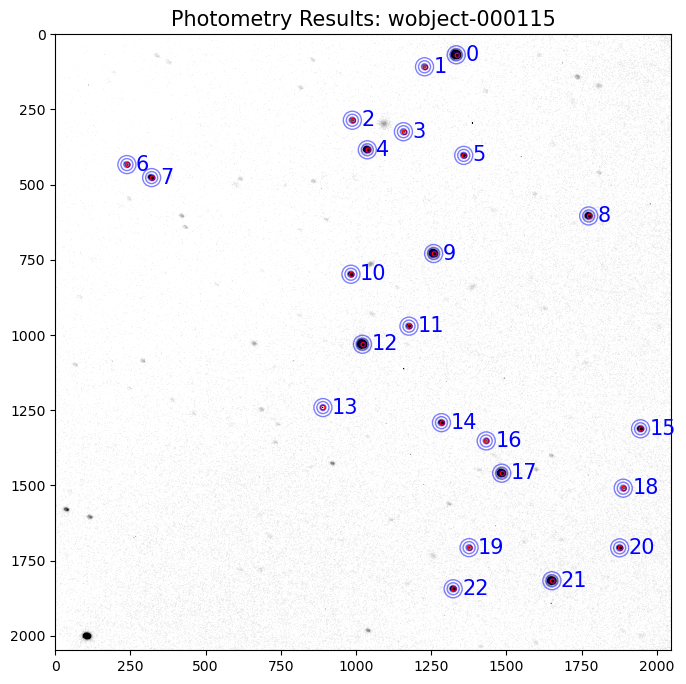

In [8]:
# PLOT the finding-chart of frame
fig, ax = plt.subplots( figsize=(8, 8), dpi=100)
z1, z2 = imed, imed + istd * 8
ax.imshow(-img, vmin=-z2, vmax=-z1, cmap='gray')
ax.scatter(allx, ally, s=10, facecolors='none', edgecolors='r')
ax.set_title('Photometry Results: ' + fidx, fontsize=15)
ax.set_xlim(0, nx)
ax.set_ylim(ny, 0)

# MARK the star that was completed for photometry
for i, stats in enumerate(results):
    maxi, background, peak, cy, cx, fwhm1, fwhm2, ang = stats

    for r in PHOT_APER:
        aper = Circle((cx, cy), r, fc='none', ec='b', alpha=0.5, lw=1)
        ax.add_patch(aper)
    ax.text(cx+max(PHOT_APER), cy, f"{i}", fontsize=15, color='b', va="center")
plt.show()

Plot the statistics of each star (find the number of star on the previous plot, 'snum')

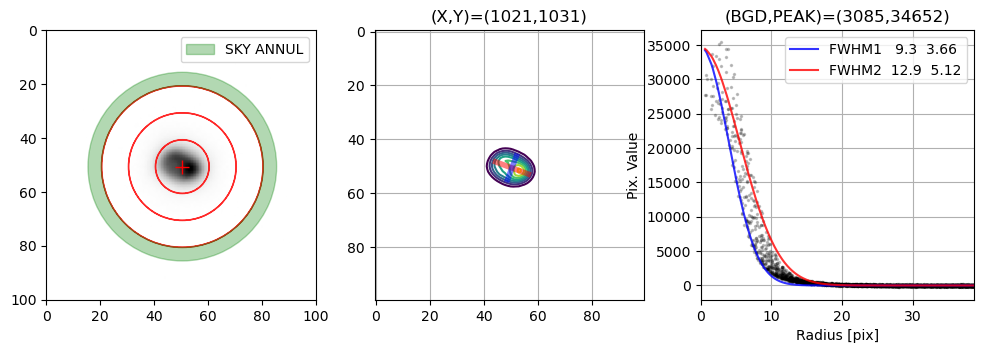

In [9]:
# SELECT the star
snum = 12

# READ the fitting parameters
maxi, background, peak, cy, cx, fwhm1, fwhm2, ang = results[snum]

# DEFINE the starting index of BOX in the imgae
x0, y0 = int(cx) - BOX, int(cy) - BOX
# CROP the image in the BOX
data = img[(y0):(y0 + 2 * BOX), (x0):(x0 + 2 * BOX)].copy()
# DEFINE the coordinate of the center in the image
cx_data, cy_data = (cx - x0), (cy - y0)
# DEFINE the arrays of coordinates and radii from the center
yy_data, xx_data = np.indices(data.shape)

figs, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(12, 3.5))
ax0.set_aspect(1)
ax1.set_aspect(1)
# plot the box image
cmin, cmax = background, background + peak
ax0.imshow(-data, vmax=-cmin, vmin=-cmax, cmap='gray')
# plot the aperture in the box image
for k in range(len(PHOT_APER)):
    apr = Wedge([cx_data, cy_data], PHOT_APER[k], 0, 360, width=BOX/500, color='r', alpha=0.8)
    ax0.add_patch(apr)
# plot the sky annulus in the box image
a_mid = (SKY_ANNUL1 + SKY_ANNUL2) / 2.0
a_wid = (SKY_ANNUL2 - SKY_ANNUL1) / 2.0
ann = Wedge([cx_data, cy_data], a_mid, 0, 360, width=a_wid, color='g', alpha=0.3, label="SKY ANNUL")
ax0.add_patch(ann)
ax0.plot(cx_data, cy_data, 'r+', ms=10, mew=1)
ax0.set_xlim(0, 2 * BOX)
ax0.set_ylim(2 * BOX, 0)
ax0.legend()

# plot the contour
levels = np.linspace(cmin, cmax, 10)
y, x = np.indices(data.shape)
ax1.contour(x, y, data, levels[2:])
ax1.set_ylim(2 * BOX - 0.5, -0.5)
ax1.set_xlim(-0.5, 2 * BOX - 0.5)
# plot the semi-major axis in contour
dx, dy = fwhm2 / 2 * np.sin(ang), fwhm2 / 2 * np.cos(ang)
ax1.plot([cx_data - dx, cx_data + dx], [cy_data - dy, cy_data + dy], 'r-', lw=4, alpha=0.5)
# plot the semi-minor axis in contour
dx, dy = fwhm1 / 2 * np.sin((ang - np.pi / 2)), fwhm1 / 2 * np.cos((ang - np.pi / 2))
ax1.plot([cx_data - dx, cx_data + dx], [cy_data - dy, cy_data + dy], 'b-', lw=4, alpha=0.5)
ax1.set_title(f'(X,Y)=({cx:.0f},{cy:.0f})')
ax1.grid()

# plot the radial profile
rsq_data = (xx_data - cx_data)**2 + (yy_data - cy_data)**2
rad_1d = np.sqrt(rsq_data.flatten())
pix_1d = data.flatten() - background
ss = np.argsort(rad_1d)
rad_x, pix_y = rad_1d[ss], pix_1d[ss]
GM1 = models.Gaussian1D(amplitude=peak, mean=0, stddev=0.5 * fwhm1 / np.sqrt(2 * np.log(2)))
GM2 = models.Gaussian1D(amplitude=peak, mean=0, stddev=0.5 * fwhm2 / np.sqrt(2 * np.log(2)))
ax2.plot(rad_x, pix_y, 'k.', ms=3, alpha=0.2)
ax2.plot(rad_x, GM1(rad_x), 'b-', alpha=0.8, label=f'FWHM1 {fwhm1:5.1f} {pfwhm1:5.2f}')
ax2.plot(rad_x, GM2(rad_x), 'r-', alpha=0.8, label=f'FWHM2 {fwhm2:5.1f} {pfwhm2:5.2f}')
ax2.set_xlabel('Radius [pix]')
ax2.set_ylabel('Pix. Value')
ax2.set_xlim(0,fwhm2*3)
ax2.legend(loc='upper right')
ax2.set_title(f'(BGD,PEAK)=({background:.0f},{peak:.0f})')
ax2.grid()
plt.show()

## Loop of All Images

Run the aperture photometry for all images.

In [3]:
# SET the file name of observation log
flog = open(LOGFILE, 'w')

#  LOOP of images for aperture photometry
for inum, fname in enumerate(flist):
    fidx = os.path.splitext(fname)[0]

    # READ the FITS file
    hdu = fits.open(fname)[0]
    img, hdr = hdu.data, hdu.header
    ny, nx = img.shape
    DATEOBS = hdr['DATE-OBS']
    TARGET = hdr['OBJECT']
    EXPTIME = hdr['EXPTIME']
    FILTER = hdr['FILTER']
    HJD = hdr.get('HJD')
    if HJD is None:
        try:
            RA = hdr['RA']
            Dec = hdr['Dec']
            HJD = helio_jd(DATEOBS, RA, Dec, exptime=EXPTIME, LAT=LAT, LON=LON, H=H)
        except:
            HJD = calc_jd(DATEOBS, exptime=EXPTIME)

    AIRMASS = hdr.get('AIRMASS')
    if AIRMASS is None:
        try:
            AIRMASS = airmass(hdr.get('ALT'))
        except:
            AIRMASS = 0
    # DISPLAY
    prnlog(f"#RUN:  {inum+1} / {NFRAME}")
    prnlog(f"#IMAGE/DATE-OBS: {fidx} {[nx, ny]} {DATEOBS}")
    prnlog(f"#OBJECT/EXPTIME/FILTER: {TARGET} {EXPTIME} {FILTER}")

    # IMAGE processing for photometry and plot
    # CALC. the sigma of image
    iavg, imed, istd = sigma_clip(img[BOX:-BOX, BOX:-BOX])
    prnlog(f"#IMAGE STATS: {imed:.2f} ({istd:.2f})")

    # FIND the stars
    ally, allx = find_stars_th(img, imed + istd * THRES, saturation=(True, SATU),
                               detection_area=int(FWHM_CUT1), margin=BOX)

    # PLOT the finding-chart of frame
    fig, ax = plt.subplots(num=1, figsize=(8, 8), dpi=100)
    z1, z2 = imed, imed + istd * 8
    ax.imshow(-img, vmin=-z2, vmax=-z1, cmap='gray')
    ax.scatter(allx, ally, s=10, facecolors='none', edgecolors='r')
    ax.set_title('Photometry Results: ' + fidx, fontsize=15)
    ax.set_xlim(0, nx)
    ax.set_ylim(ny, 0)

    results = []
    # LOOP of the stars found by thresholds
    for fx, fy in zip(allx, ally):
        # CHECK the margin stars
        if (fx > nx-BOX) | (fx < BOX) | (fy > ny-BOX) | (fy < BOX): continue

        # DEFINE the box for fitting
        x0, y0 = int(fx) - BOX, int(fy) - BOX
        data = img[(y0):(y0 + 2 * BOX), (x0):(x0 + 2 * BOX)].copy()

        # FIT the stellar profile with 2D Gaussian function
        results.append(fit_gauss_elliptical([y0, x0], data))
        del data

    # OPEN the output file of Aperture Photometry
    fout = open(fidx + '.apw', 'w')
    # for checking the duplicate stars
    xlist, ylist = [], []
    # LOOP of the results by fitting the stars
    for maxi, background, peak, cy, cx, fwhm1, fwhm2, ang in results:
        # CHECK the margin stars
        if (cx > nx - BOX) | (cx < BOX) | (cy > ny - BOX) | (cy < BOX): continue

        # CALC FWHM in arcsec
        pfwhm1, pfwhm2 = fwhm1 * PSCALE, fwhm2 * PSCALE

        # CHECK the condition of star
        error_msg = ''
        if peak < istd:
            error_msg += 'TOO WEAK, '
        if (fwhm2 < FWHM_CUT1) | (fwhm2 > FWHM_CUT2):
            error_msg += 'TOO LARGE/SMALL, '
        if fwhm1 / fwhm2 < FWHM_ECC:
            error_msg += 'TOO OVAL, '
        if len(xlist) >= 1:
            c_rsq = (np.array(xlist) - cx)**2 + (np.array(ylist) - cy)**2
            if min(c_rsq) < FWHM_CUT2 ** 2:
                error_msg += 'TOO CLOSE, '
        if error_msg != '':
            prnlog(f'{fidx} {cx:.0f} {cy:.0f} [FAIL] FWHM={pfwhm2:.1f}" PEAK={peak:.1f} A/B={fwhm1/fwhm2:.1f} ' +
                   f'{error_msg}')
            continue

        # DEFINE the starting index of BOX in the imgae
        x0, y0 = int(cx) - BOX, int(cy) - BOX
        # CROP the image in the BOX
        data = img[(y0):(y0 + 2 * BOX), (x0):(x0 + 2 * BOX)].copy()
        # DEFINE the coordinate of the center in the image
        cx_data, cy_data = (cx - x0), (cy - y0)
        # DEFINE the arrays of coordinates and radii from the center
        yy_data, xx_data = np.indices(data.shape)
        rsq = (xx_data - cx_data)**2 + (yy_data - cy_data)**2

        # DETERMINE sky backgrounds
        cond = (SKY_ANNUL1 ** 2 < rsq) & (rsq < SKY_ANNUL2 ** 2)
        bgdpixels = data[cond].flatten()
        bcnt = len(bgdpixels)
        bavg, bmed, bsig = sigma_clip(bgdpixels)
        bvar = bsig ** 2
        bmed = bmed

        # APPLY subpixel method for precise photometry
        if SUBPIXEL == 1:
            subdata = data
        else:
            subdata = np.zeros([2 * BOX * SUBPIXEL, 2 * BOX * SUBPIXEL])
            for i in range(SUBPIXEL):
                for j in range(SUBPIXEL):
                    subdata[i::SUBPIXEL, j::SUBPIXEL] = data[:, :] / float(SUBPIXEL ** 2)

        # DEFINE the array of radii from the center in sub-pixels
        yy_sub, xx_sub = np.indices(subdata.shape) / float(SUBPIXEL)
        subrsq = (xx_sub - cx_data)**2 + (yy_sub - cy_data)**2

        # DEFINE the list for each aperture
        aflx, aferr, amag, amerr = [], [], [], []
        # LOOP for the aperture sizes
        for k in range(N_APER):
            flxpixels = subdata[subrsq < (PHOT_APER[k]) ** 2].flatten()
            ssum = np.sum(flxpixels)
            scnt = float(len(flxpixels)) / float(SUBPIXEL ** 2)

            # CALC. the total flux and magnitude of the star
            flx, ferr, mag, merr = cal_magnitude(ssum, bmed, bvar, scnt, bcnt, gain=EGAIN)
            mag = mag + 2.5 * np.log10(EXPTIME)
            flx, ferr = flx / EXPTIME, ferr / EXPTIME

            # SAVE into the list
            aflx.append(flx)
            aferr.append(ferr)
            amag.append(mag)
            amerr.append(merr)

        # CHECK the flux
        if min(aflx) < 0:
            error_msg = f'Negative flux={aflx}'
            prnlog(f'{fidx} {cx:.0f} {cy:.0f} [FAIL] FWHM={pfwhm2:.1f}" PEAK={peak:.1f} A/B={fwhm1/fwhm2:.1f} ' +
                   f'{error_msg}')
            continue

        # WRITE photometry info. into the file
        fstr = '%9.3f %9.3f ' % (cx, cy)
        fstr1, fstr2, fstr3, fstr4 = '', '', '', ''
        for k in range(N_APER):
            fstr1 = fstr1 + '%12.3f ' % (aflx[k],)
            fstr2 = fstr2 + '%12.3f ' % (aferr[k],)
            fstr3 = fstr3 + '%8.4f ' % (amag[k],)
            fstr4 = fstr4 + '%8.4f ' % (amerr[k],)
        fstr = fstr + fstr1 + fstr2 + fstr3 + fstr4
        fstr = fstr + '%12.3f %12.3f' % (bmed, bsig)
        fout.write(fstr + "\n")

        # MARK the star that was completed for photometry
        for Rap in PHOT_APER:
            aper = Circle((cx, cy), Rap, fc='none', ec='b', alpha=0.5, lw=1)
            ax.add_patch(aper)

        # SAVE the coordinate of valid stars
        xlist.append(cx)
        ylist.append(cy)

        # PLOT the each star profile and image
        if PLOT_FLAG:

            figs, (ax0, ax1, ax2) = plt.subplots(num=99, ncols=3, figsize=(12, 3.5))
            ax0.set_aspect(1)
            ax1.set_aspect(1)
            # plot the box image
            cmin, cmax = background, background + peak
            ax0.imshow(-data, vmax=-cmin, vmin=-cmax, cmap='gray')
            # plot the aperture in the box image
            for k in range(len(PHOT_APER)):
                apr = Wedge([cx_data, cy_data], PHOT_APER[k], 0, 360, width=BOX/500, color='r', alpha=0.8)
                ax0.add_patch(apr)
            # plot the sky annulus in the box image
            a_mid = (SKY_ANNUL1 + SKY_ANNUL2) / 2.0
            a_wid = (SKY_ANNUL2 - SKY_ANNUL1) / 2.0
            ann = Wedge([cx_data, cy_data], a_mid, 0, 360, width=a_wid, color='g', alpha=0.3)
            ax0.add_patch(ann)
            ax0.plot(cx_data, cy_data, 'r+', ms=10, mew=1)
            ax0.set_xlim(0, 2 * BOX)
            ax0.set_ylim(2 * BOX, 0)

            # plot the contour
            levels = np.linspace(cmin, cmax, 10)
            y, x = np.indices(data.shape)
            ax1.contour(x, y, data, levels[2:])
            ax1.set_ylim(2 * BOX - 0.5, -0.5)
            ax1.set_xlim(-0.5, 2 * BOX - 0.5)
            # plot the semi-major axis in contour
            dx, dy = fwhm2 / 2 * np.sin(ang), fwhm2 / 2 * np.cos(ang)
            ax1.plot([cx_data - dx, cx_data + dx], [cy_data - dy, cy_data + dy], 'r-', lw=4, alpha=0.5)
            # plot the semi-minor axis in contour
            dx, dy = fwhm1 / 2 * np.sin((ang - np.pi / 2)), fwhm1 / 2 * np.cos((ang - np.pi / 2))
            ax1.plot([cx_data - dx, cx_data + dx], [cy_data - dy, cy_data + dy], 'b-', lw=4, alpha=0.5)
            ax1.set_title(f'(X,Y)=({cx:.0f},{cy:.0f})')
            ax1.grid()

            # plot the radial profile
            rsq_data = (xx_data - cx_data)**2 + (yy_data - cy_data)**2
            rad_1d = np.sqrt(rsq_data.flatten())
            pix_1d = data.flatten() - background
            ss = np.argsort(rad_1d)
            rad_x, pix_y = rad_1d[ss], pix_1d[ss]
            GM1 = models.Gaussian1D(amplitude=peak, mean=0, stddev=0.5 * fwhm1 / np.sqrt(2 * np.log(2)))
            GM2 = models.Gaussian1D(amplitude=peak, mean=0, stddev=0.5 * fwhm2 / np.sqrt(2 * np.log(2)))
            ax2.plot(rad_x, pix_y, 'k.', ms=3, alpha=0.2)
            ax2.plot(rad_x, GM1(rad_x), 'b-', alpha=0.8, label=f'FWHM1 {fwhm1:5.1f} {pfwhm1:5.2f}')
            ax2.plot(rad_x, GM2(rad_x), 'r-', alpha=0.8, label=f'FWHM2 {fwhm2:5.1f} {pfwhm2:5.2f}')
            ax2.set_xlabel('Radius [pix]')
            ax2.set_ylabel('Pix. Value')
            ax2.set_xlim(0,fwhm2*3)
            ax2.legend(loc='upper right')
            ax2.set_title(f'(BGD,PEAK)=({background:.0f},{peak:.0f})')
            #ax2.text(0.5, 0.99, strtmp, fontweight='bold', color='k', alpha=0.7, ha='center', va='top', transform=ax2.transAxes, fontsize=12)
            ax2.grid()

            if not os.path.exists('./prof/'):
                os.makedirs('./prof/')
            figs.savefig(f'./prof/{fidx}-{cx:04.0f}_{cy:04.0f}.png')
            figs.clf()
            del data, subdata, rsq, subrsq

    # SAVE/CLOSE image figure 
    fig.savefig(fidx + '-phots')
    plt.close('all')

    # CLOSE .apw file
    fout.close()
    prnlog('%i stars of %i completed...' % (len(xlist), len(allx)))

    # WRITE observation log 
    flog.write(f'{inum:04.0f} {fidx} {HJD:.8f} {EXPTIME:5.0f} {AIRMASS:9.7f} {FILTER}\n')

# CLOSE log and print files
flog.close()

# RETURN to the directory ===========
os.chdir(CDIR) 
#====================================

#RUN:  1 / 44
#IMAGE/DATE-OBS: wobject-000115 [2048, 2048] 2018-03-26T14:04:06
#OBJECT/EXPTIME/FILTER: hat-p-12b 200.0 R
#IMAGE STATS: 3057.72 (59.18)
 - NUMBER of detected stars: 23
wobject-000115 890 1241 [FAIL] FWHM=0.5" PEAK=5128.9 A/B=0.9 TOO LARGE/SMALL, 
22 stars of 23 completed...
#RUN:  2 / 44
#IMAGE/DATE-OBS: wobject-000116 [2048, 2048] 2018-03-26T14:07:37
#OBJECT/EXPTIME/FILTER: hat-p-12b 200.0 R
#IMAGE STATS: 3014.46 (58.85)
 - NUMBER of detected stars: 23
wobject-000116 1230 107 [FAIL] FWHM=5.0" PEAK=4565.6 A/B=0.0 TOO OVAL, 
wobject-000116 598 460 [FAIL] FWHM=1.4" PEAK=1961.5 A/B=0.3 TOO LARGE/SMALL, TOO OVAL, 
wobject-000116 1759 1555 [FAIL] FWHM=0.7" PEAK=6448.0 A/B=0.8 TOO LARGE/SMALL, 
20 stars of 23 completed...
#RUN:  3 / 44
#IMAGE/DATE-OBS: wobject-000117 [2048, 2048] 2018-03-26T14:11:04
#OBJECT/EXPTIME/FILTER: hat-p-12b 200.0 R
#IMAGE STATS: 2981.93 (58.48)
 - NUMBER of detected stars: 18
wobject-000117 984 1551 [FAIL] FWHM=0.5" PEAK=5034.7 A/B=0.9 TOO LARGE/SMALL